In [8]:
#Installing Library
!pip install opencv-contrib-python opencv-python-headless opencv-python tqdm
!pip install tf_explain
!apt-get update && apt-get install libgl1 -y


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.2 MB/s eta 0:00:00ta 0:00:01
Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1 is already the newest version (1.3.2-1~ubuntu0.20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In [156]:
!pip install silence-tensorflow

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4477 sha256=f4d63eeb5a2f6fb04c84f58084692a01e0062cb98e85cc137f13e5956a393b29
  Stored in directory: /root/.cache/pip/wheels/19/a3/b3/88021fd4ff3a82ed03067ca8935323b55ca23ec8e21b2e44e0
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5652 sha256=7793914d2074c9ae54db8e9df2e18fc6a9ea580f40a1cadacfe4a343cda9e825
  Stored in directory: /root/.cache/pip/wheels/11/5e/63/51e84640e77a7dc5f1e5f5eb597e8f1bc730a2818ee5c3fc03
Successfully built silence-tensorflow support_developer


In [191]:
#importing library
import cv2
import os
import glob
from tqdm import tqdm
import numpy as np
np.random.seed = 42
import matplotlib.pyplot as plt
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

Data collection and preprocessing:

Collect the necessary image data for the segmentation task and preprocess it by resizing, normalizing, and augmenting the images. Split the dataset into training, validation, and test sets.

In [192]:
## root directory
root_dir = 'archive/Dataset_BUSI_with_GT'
os.listdir(root_dir)

['benign', 'normal', 'malignant']

In [193]:
IMG_WIDTH = 128
IMG_HIGH = 128
IMG_CHANNELS = 3 # number of input channels

In [194]:
def LoadData(root_dir, FolderName, img_width=IMG_WIDTH, img_high=IMG_HIGH, img_channels=IMG_CHANNELS):
  num_samples = 0
  for address in glob.glob(root_dir + f'/{FolderName}/*'):
    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')
    if len(s_address) == 1:
      num_samples += 1

  X = np.zeros((num_samples, img_high, img_width, img_channels), dtype=np.uint8)
  Y = np.zeros((num_samples, img_high, img_width, 1), dtype=np.bool8)


  for address in tqdm(glob.glob(root_dir + f'/{FolderName}/*')):
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (img_width, img_high), interpolation=cv2.INTER_CUBIC)

    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')

    idx = s_address[0]
    idx = int(idx.split('(')[1].split(')')[0]) - 1

    if len(s_address) == 1:
      X[idx] = resized_image
      
    elif len(s_address) > 1:
      mask = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
      
      mask = np.expand_dims(mask, axis=-1)
      Y[idx] = np.maximum(mask, Y[idx])

  return X, Y

In [195]:
x_benign, y_benign = LoadData(root_dir, 'benign')
x_malignant, y_malignant = LoadData(root_dir, 'malignant')
x_normal, y_normal = LoadData(root_dir, 'normal')

X = np.concatenate((x_benign, x_malignant, x_normal), axis=0)
Y = np.concatenate((y_benign, y_malignant, y_normal), axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:01<00:00, 134.89it/s]


In [196]:
X.shape, Y.shape

((780, 128, 128, 3), (780, 128, 128, 1))

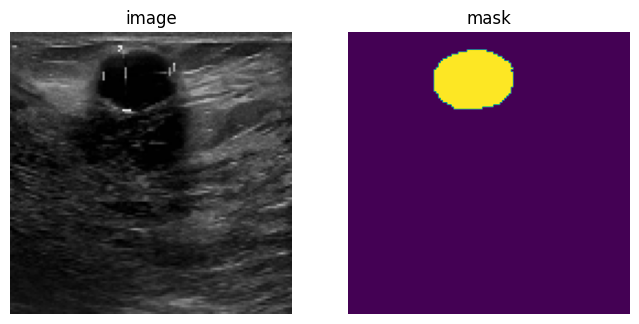

In [199]:
## displaying data loaded by our function
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(X[78])
plt.title('image')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(tf.squeeze(Y[78]))
plt.title('mask')
plt.axis('off');

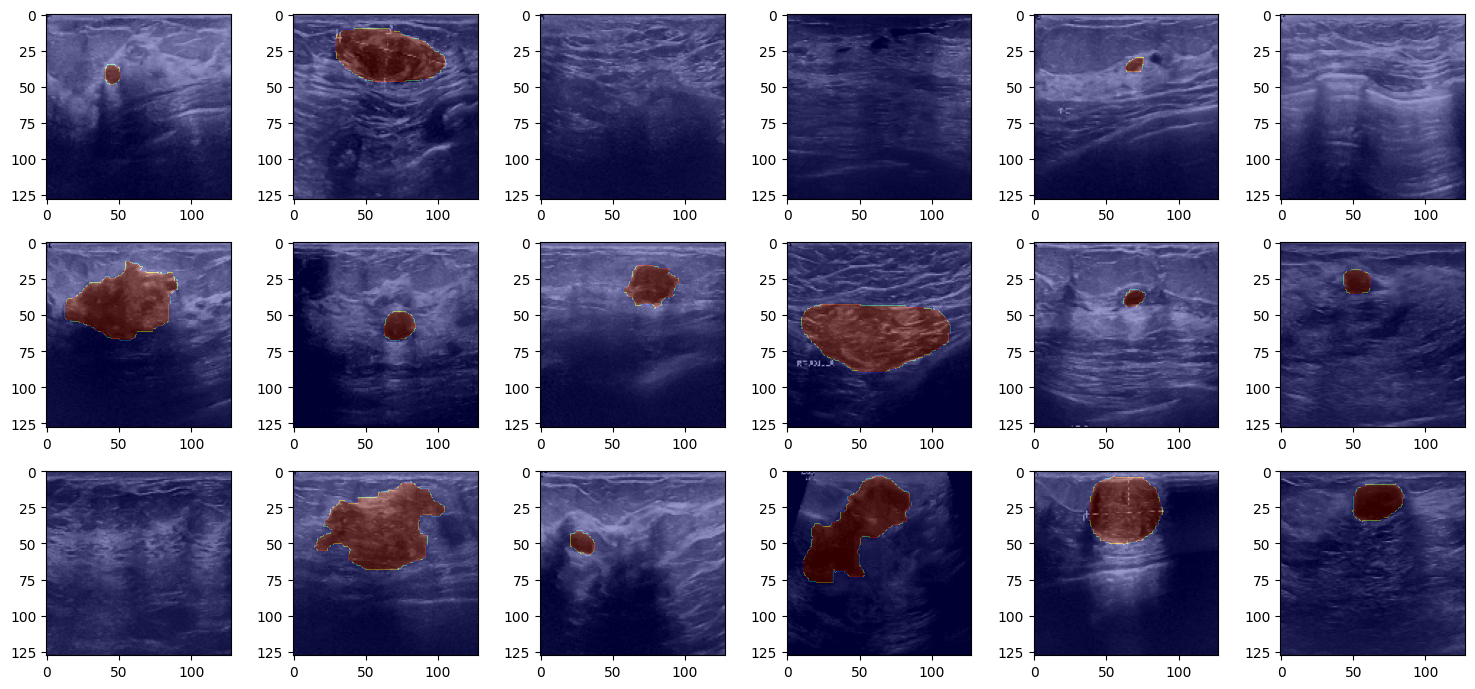

In [210]:
plt.figure(figsize=(15,7))
for i in range(18):
    plt.subplot(3,6,i+1)
    idx = np.random.randint(0, len(X))
    plt.imshow(X[idx])
    plt.imshow(tf.squeeze(Y[idx]), cmap='jet', alpha=0.4)
    plt.axis('on')
plt.tight_layout()
plt.show()

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(624, 128, 128, 3) (156, 128, 128, 3) (624, 128, 128, 1) (156, 128, 128, 1)


In [212]:
""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 100
model_path = 'model.h5'
csv_path = 'data.csv'
train_steps = len(X_train)//batch_size

In [213]:
#GPU Accleration is Available
print(tf.test.is_gpu_available())

True


2023-04-20 08:25:24.331928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /device:GPU:0 with 14459 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


In [214]:
#Checking the GPU Specification
!nvidia-smi

Thu Apr 20 08:25:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:AF:00.0 Off |                    0 |
| N/A   74C    P0    48W / 250W |  15381MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Model selection:

Choose an appropriate model for image segmentation. One of the popular models for this task is the U-Net model, which is a convolutional neural network that consists of an encoder and a decoder.

The encoder downsamples the input image to capture the context, while the decoder upsamples the features to generate a segmentation mask.

In [239]:
def Conv_Block(inputs, num_filters, kernel_size=3):

    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                              kernel_initializer = 'he_normal', padding = 'same') (inputs)
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [240]:
inputs = keras.layers.Input(shape=(IMG_HIGH, IMG_WIDTH, IMG_CHANNELS))
inputs_ = layers.Lambda(lambda x: x/255.0)(inputs)

#Contraction path
conv1 = Conv_Block(inputs_, 16)
pool1 = layers.MaxPooling2D((3,3), strides = 2, padding = 'same')(conv1)
drop1 = layers.Dropout(0.2)(pool1)

conv2 = Conv_Block(drop1, 32)
pool2 = layers.MaxPooling2D((3,3), strides = 2, padding = 'same')(conv2)
drop2 = layers.Dropout(0.2)(pool2)

conv3 = Conv_Block(drop2, 64)
pool3 = layers.MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
drop3 = layers.Dropout(0.1)(pool3)

conv4 = Conv_Block(drop3, 128)
pool4 = layers.MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
drop4 = layers.Dropout(0.1)(pool4)

conv5 = Conv_Block(drop4, 256)
pool5 = layers.MaxPooling2D((2,2), strides = 2, padding = 'same')(conv5)
drop5 = layers.Dropout(0.1)(pool5)

conv6 = Conv_Block(drop5, 512)
drop6 = layers.Dropout(0.1)(conv6)

#Expansion path 
tran6 = layers.Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(drop5)
conc6 = layers.concatenate([tran6, conv5])
drop6 = layers.Dropout(0.1)(conc6)
conv6 = Conv_Block(drop6, 128)

tran7 = layers.Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(drop6)
conc7 = layers.concatenate([tran7, conv4])
drop7 = layers.Dropout(0.1)(conc7)
conv7 = Conv_Block(drop7, 64)

tran8 = layers.Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(drop7)
conc8 = layers.concatenate([tran8, conv3])
drop8 = layers.Dropout(0.1)(conc8)
conv8 = Conv_Block(drop8, 32)

tran9 = layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(drop8)
conc9 = layers.concatenate([tran9, conv2])
drop9 = layers.Dropout(0.2)(conc9)
conv9 = Conv_Block(drop9, 16)

tran10 = layers.Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(drop9)
conc10 = layers.concatenate([tran10, conv1])
drop10 = layers.Dropout(0.2)(conc10)
conv10 = Conv_Block(drop10, 16)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv10)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()


Model: "model_249"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_14 (Lambda)             (None, 128, 128, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv2d_322 (Conv2D)            (None, 128, 128, 16  448         ['lambda_14[0][0]']              
                                )                                                                 
                                                                                          

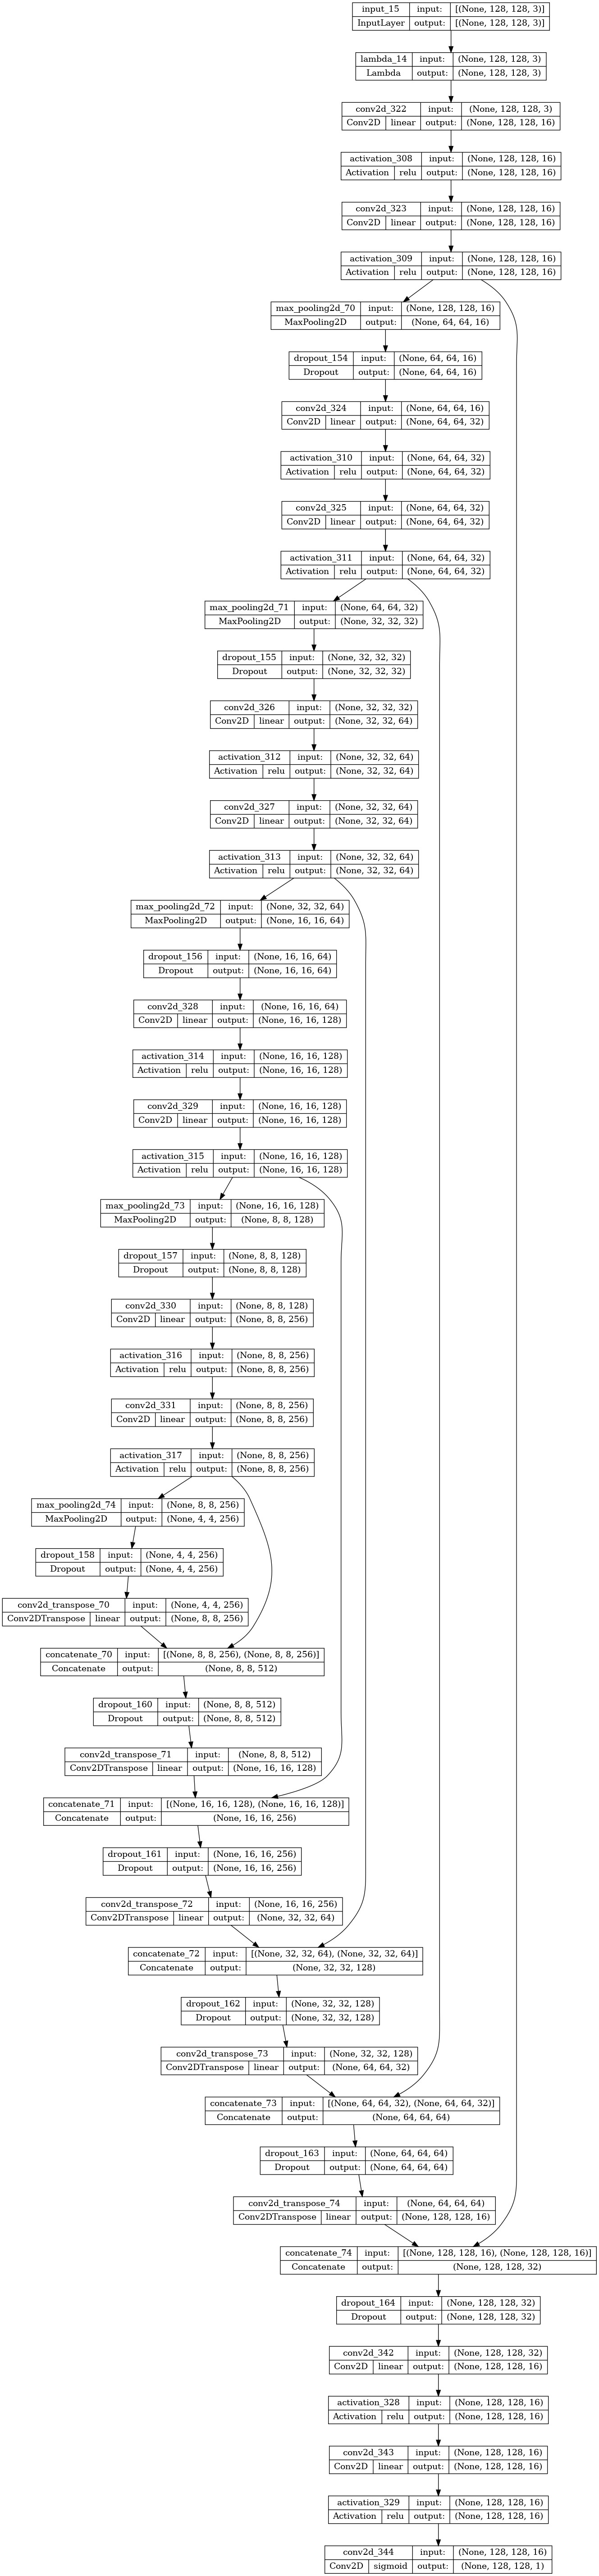

In [241]:
tf.keras.utils.plot_model(model, show_shapes=True,show_layer_activations=True)

Model training:

Train the selected model on the training data using an appropriate loss function such as binary cross-entropy loss or Dice coefficient loss. Use a suitable optimizer such as Adam or RMSprop, and train the model for multiple epochs.

In [243]:
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy',dice_coef, iou, Recall(), Precision()])
callbacks = [ ModelCheckpoint(f"{num_epochs}model.h5", verbose=2, save_best_only=True),
              ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, min_lr=1e-6, verbose=2),
              CSVLogger(csv_path),
              TensorBoard(log_dir='logs'),
              EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
            ]


In [244]:
#Metrics for LOSS calculation and Metrics calculation
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [246]:
results = model.fit(X_train, y_train, steps_per_epoch=train_steps, validation_split=0.1, batch_size=8, epochs=200, callbacks=callbacks)

Epoch 1/200
312/312 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9610 - dice_coef: 0.5913 - iou: 0.4286 - recall_15: 0.6264 - precision_15: 0.8325
Epoch 1: val_loss improved from 0.12081 to 0.10445, saving model to 100model.h5
312/312 [==============================] - 10s 33ms/step - loss: 0.1044 - accuracy: 0.9610 - dice_coef: 0.5913 - iou: 0.4286 - recall_15: 0.6264 - precision_15: 0.8325 - val_loss: 0.1045 - val_accuracy: 0.9632 - val_dice_coef: 0.5416 - val_iou: 0.3777 - val_recall_15: 0.5866 - val_precision_15: 0.8619 - lr: 1.0000e-04
Epoch 2/200
311/312 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9664 - dice_coef: 0.6456 - iou: 0.4869 - recall_15: 0.6863 - precision_15: 0.8575
Epoch 2: val_loss improved from 0.10445 to 0.09501, saving model to 100model.h5
312/312 [==============================] - 11s 35ms/step - loss: 0.0890 - accuracy: 0.9665 - dice_coef: 0.6462 - iou: 0.4875 - recall_15: 0.6866 - precision_15: 0.8576 - va

Model testing:

Test the final model on the test set and evaluate the performance using the same metrics as used for validation. Visualize the segmentation results to assess the model's performance qualitatively.

In [247]:
def predict_func(model, image, mask):
  y_pred = model.predict(image[np.newaxis,...])

  exp = GradCAM()
  pred_mask = model.predict(image[np.newaxis,...])
  cam = exp.explain(
      validation_data=(image[np.newaxis,...], mask),
      class_index=1,
      layer_name = model.layers[-1].name,
      model=model
  )

  return y_pred, cam

1/1 [==============================] - 0s 28ms/step


/tmp/ipykernel_776/3535125446.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,8))


1/1 [==============================] - 0s 28ms/step


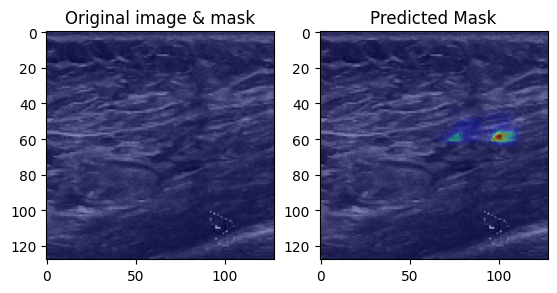

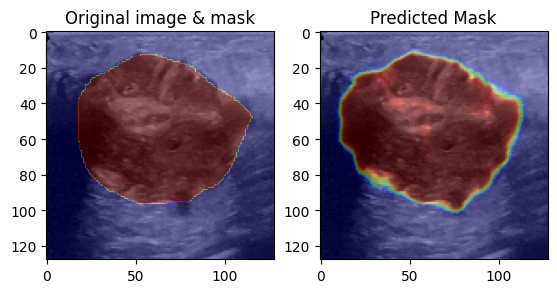

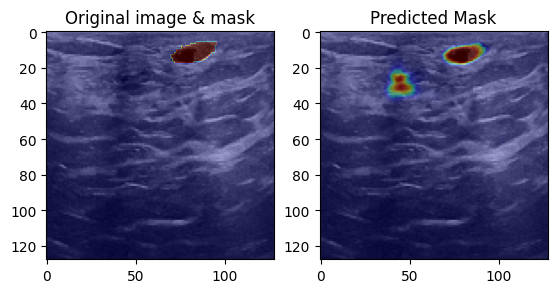

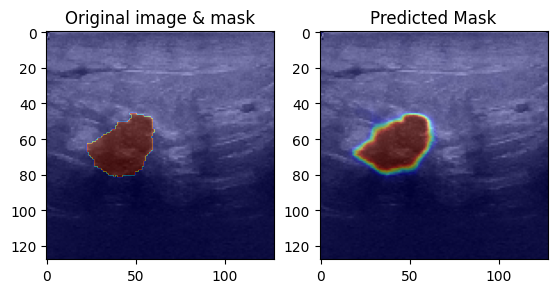

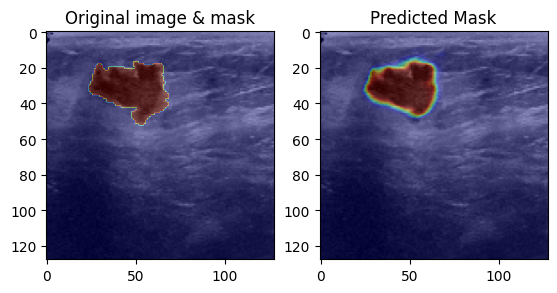

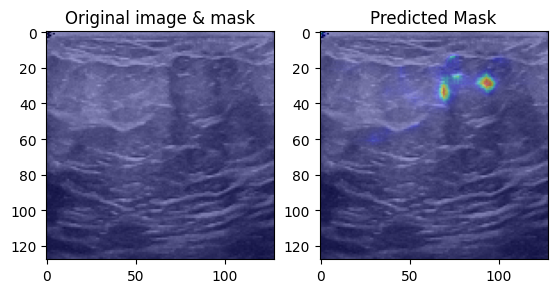

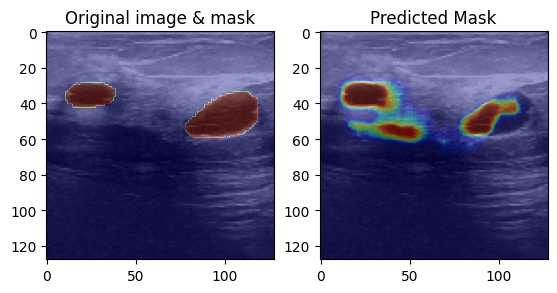

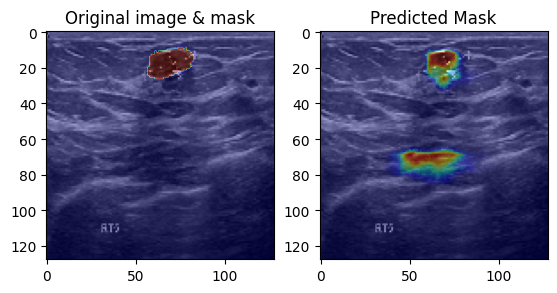

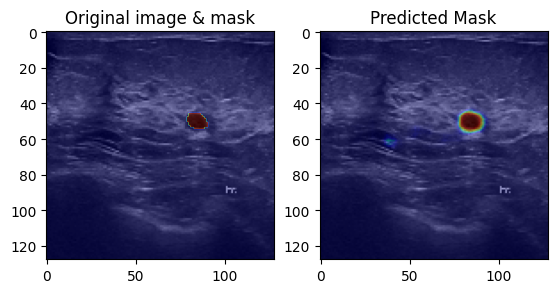

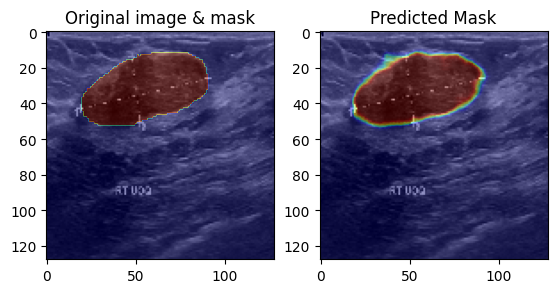

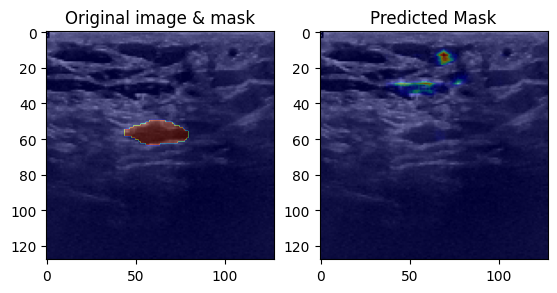

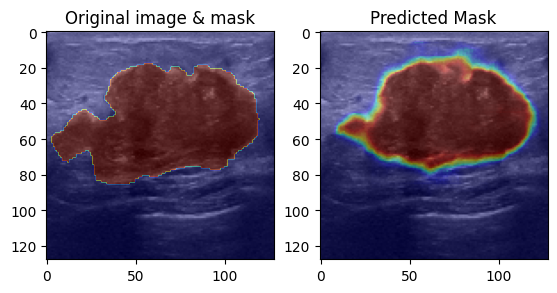

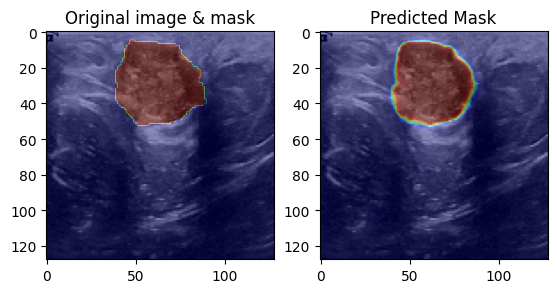

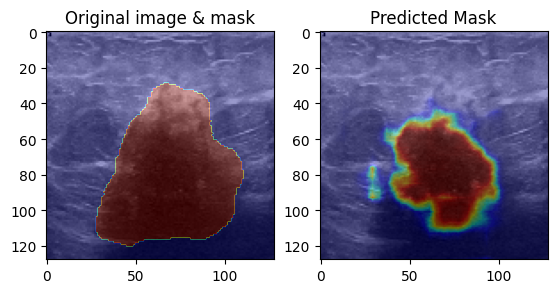

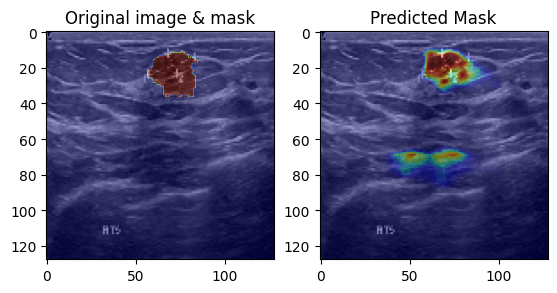

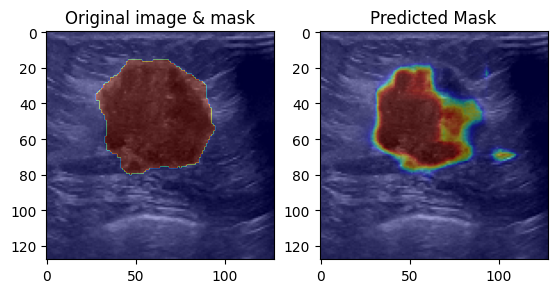

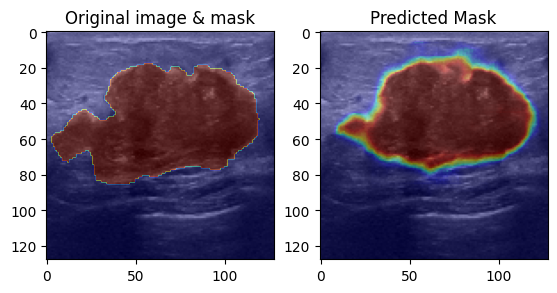

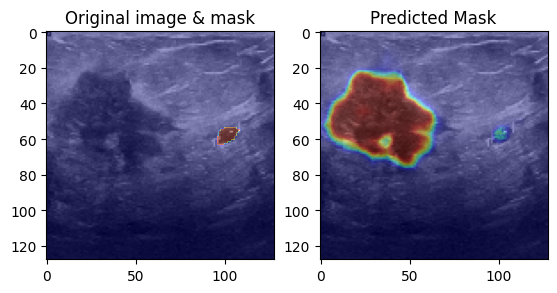

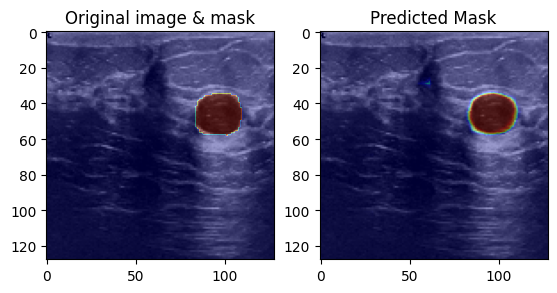

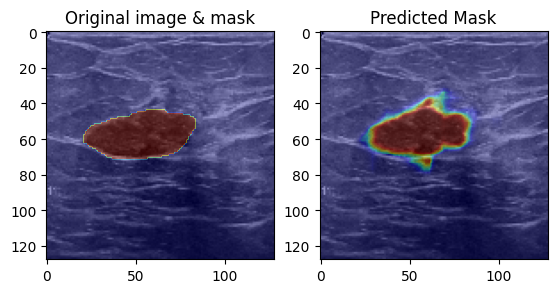

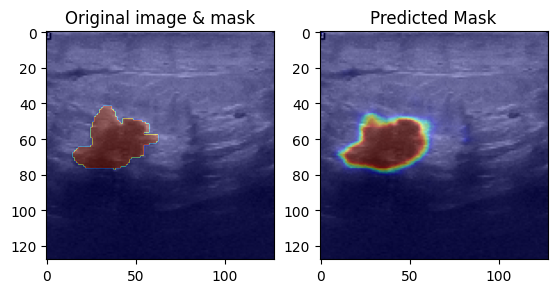

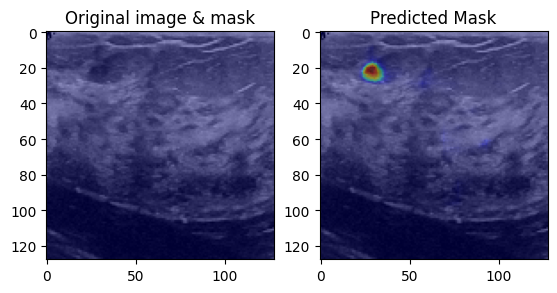

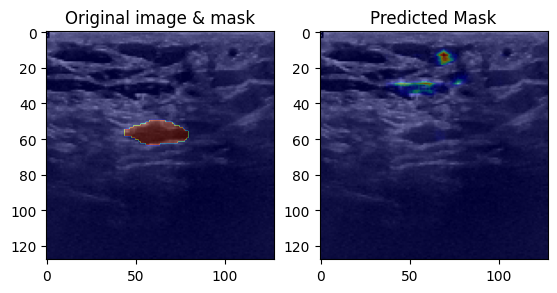

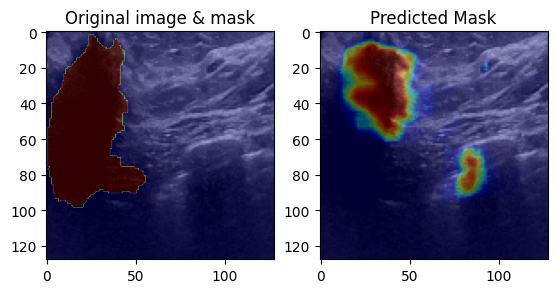

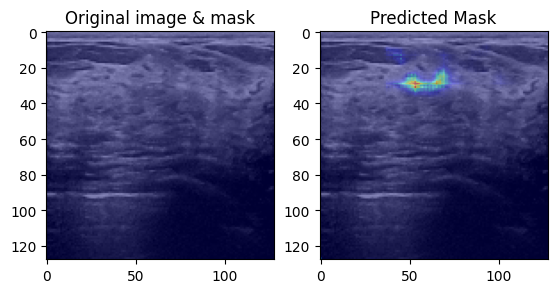

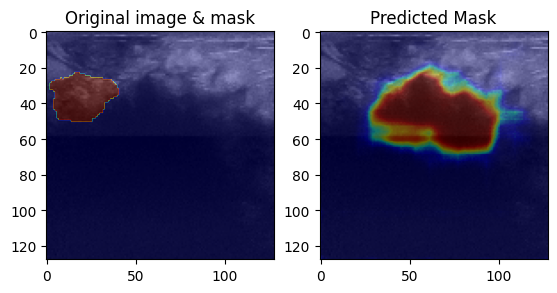

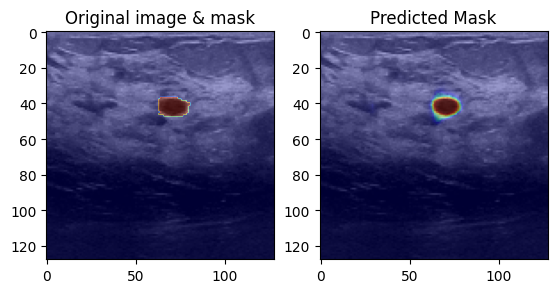

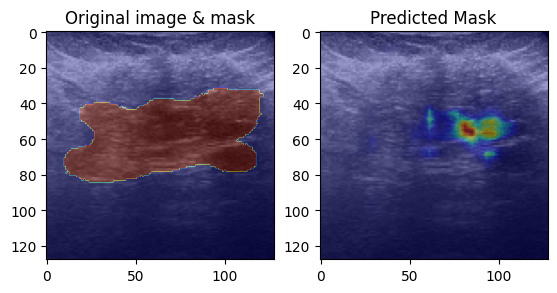

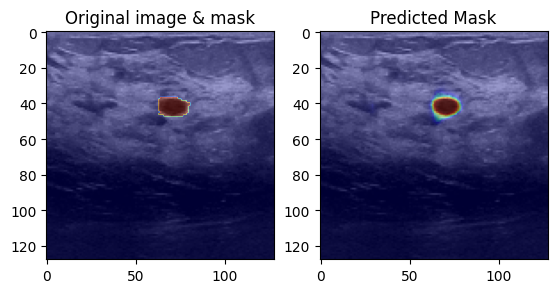

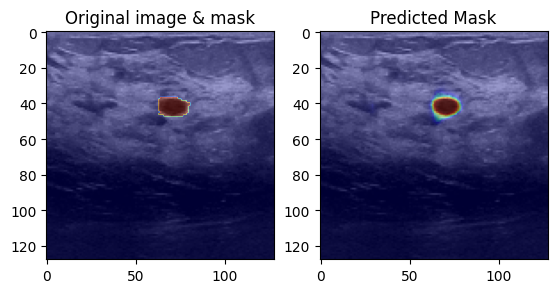

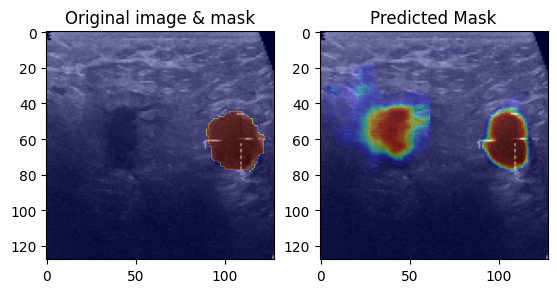

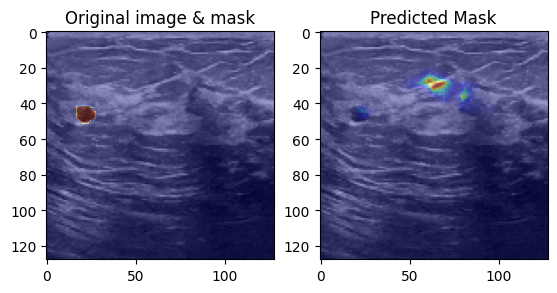

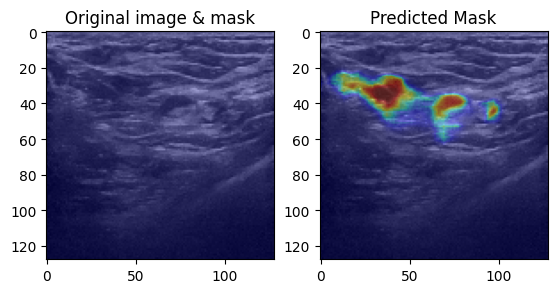

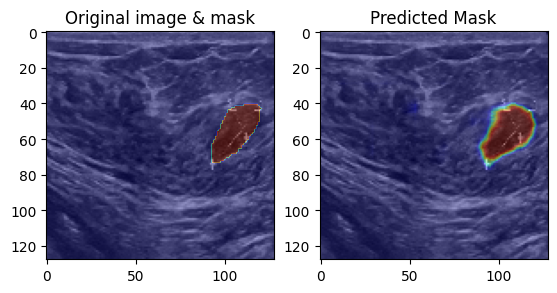

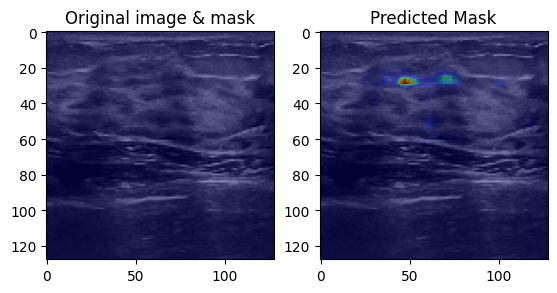

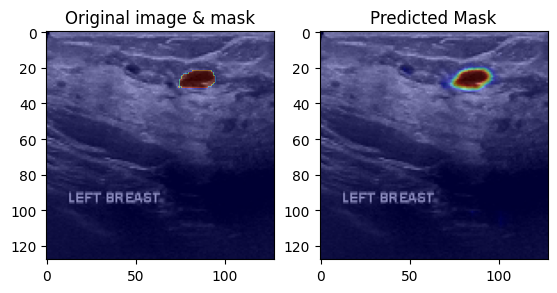

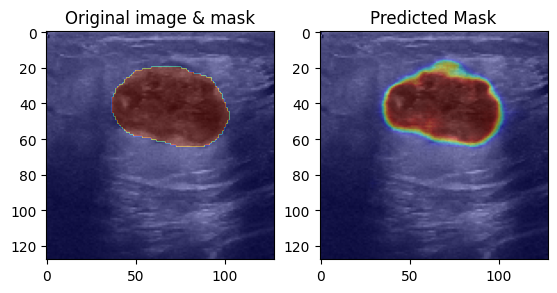

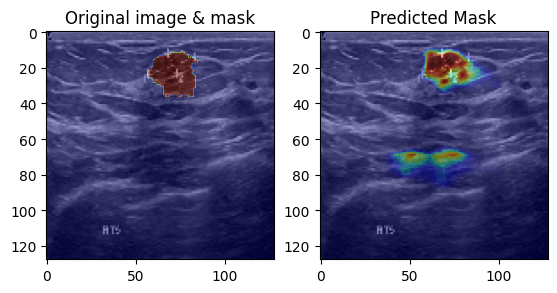

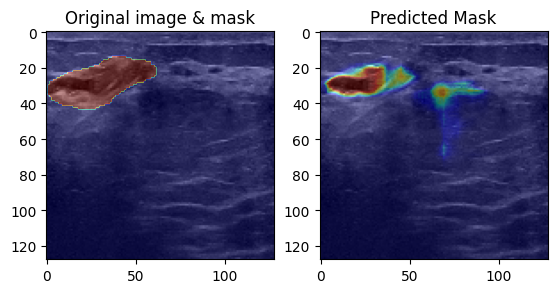

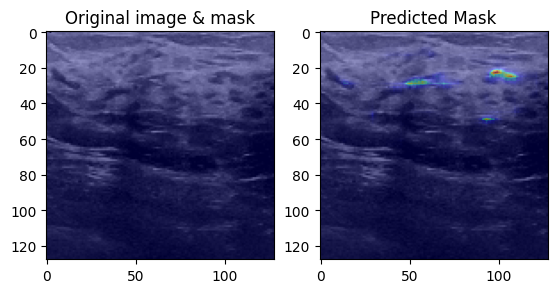

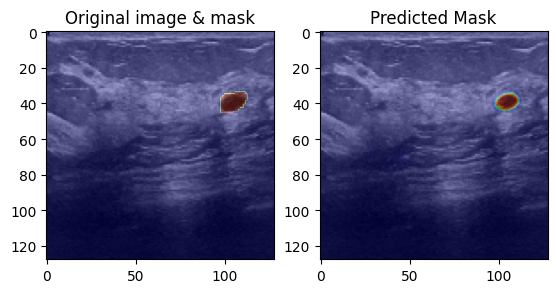

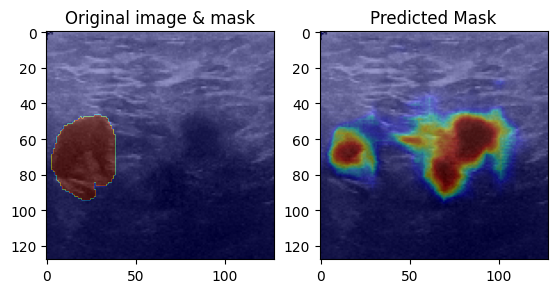

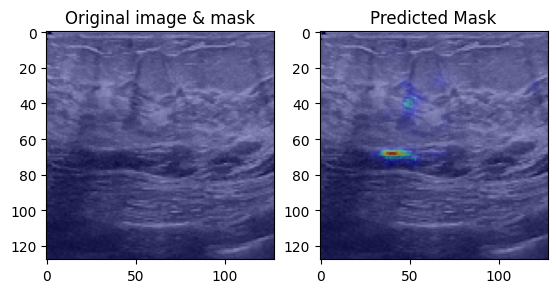

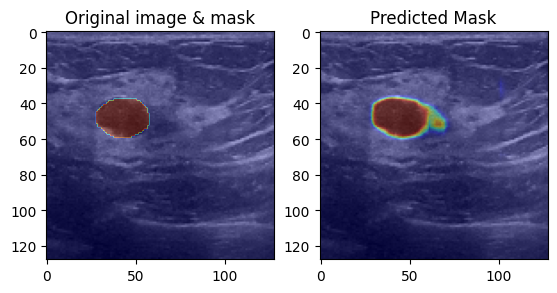

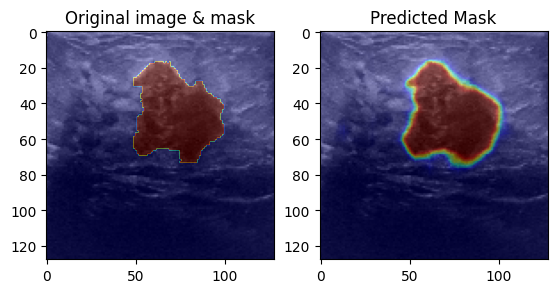

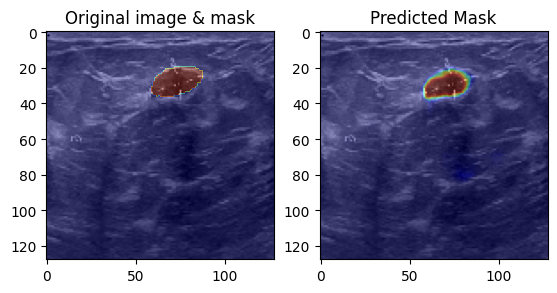

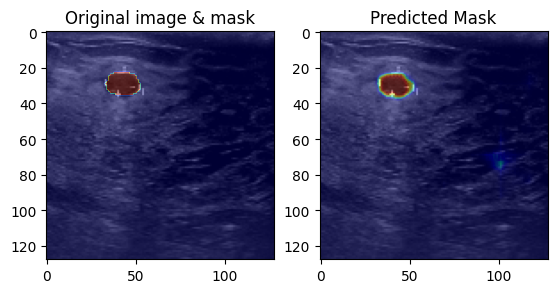

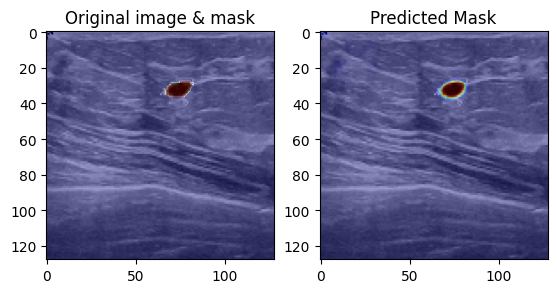

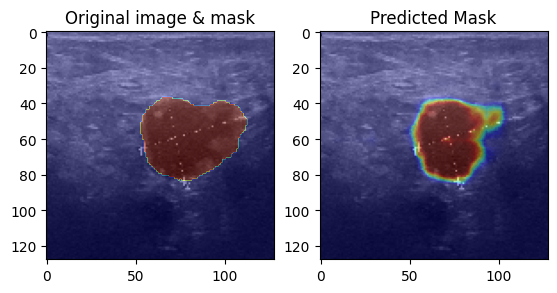

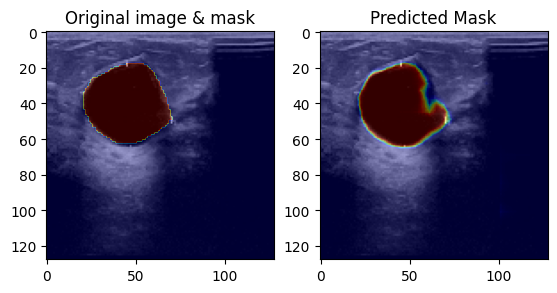

In [248]:
for i in range(50):
    id = np.random.randint(len(X_test))
    image = X_test[id]
    mask = y_test[id]
    pred_mask, cam = predict_func(model, image, mask)

    plt.figure(figsize=(10,8))
    plt.subplot(1,3,1)
    plt.title("Original image & mask")
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap='jet', alpha=0.4)
    plt.axis('on')

    plt.subplot(1,3,2)
    plt.title("Predicted Mask")
    plt.imshow(image)
    plt.imshow(tf.squeeze(pred_mask), cmap='jet', alpha=0.4)
    plt.axis('on')

##Save Model

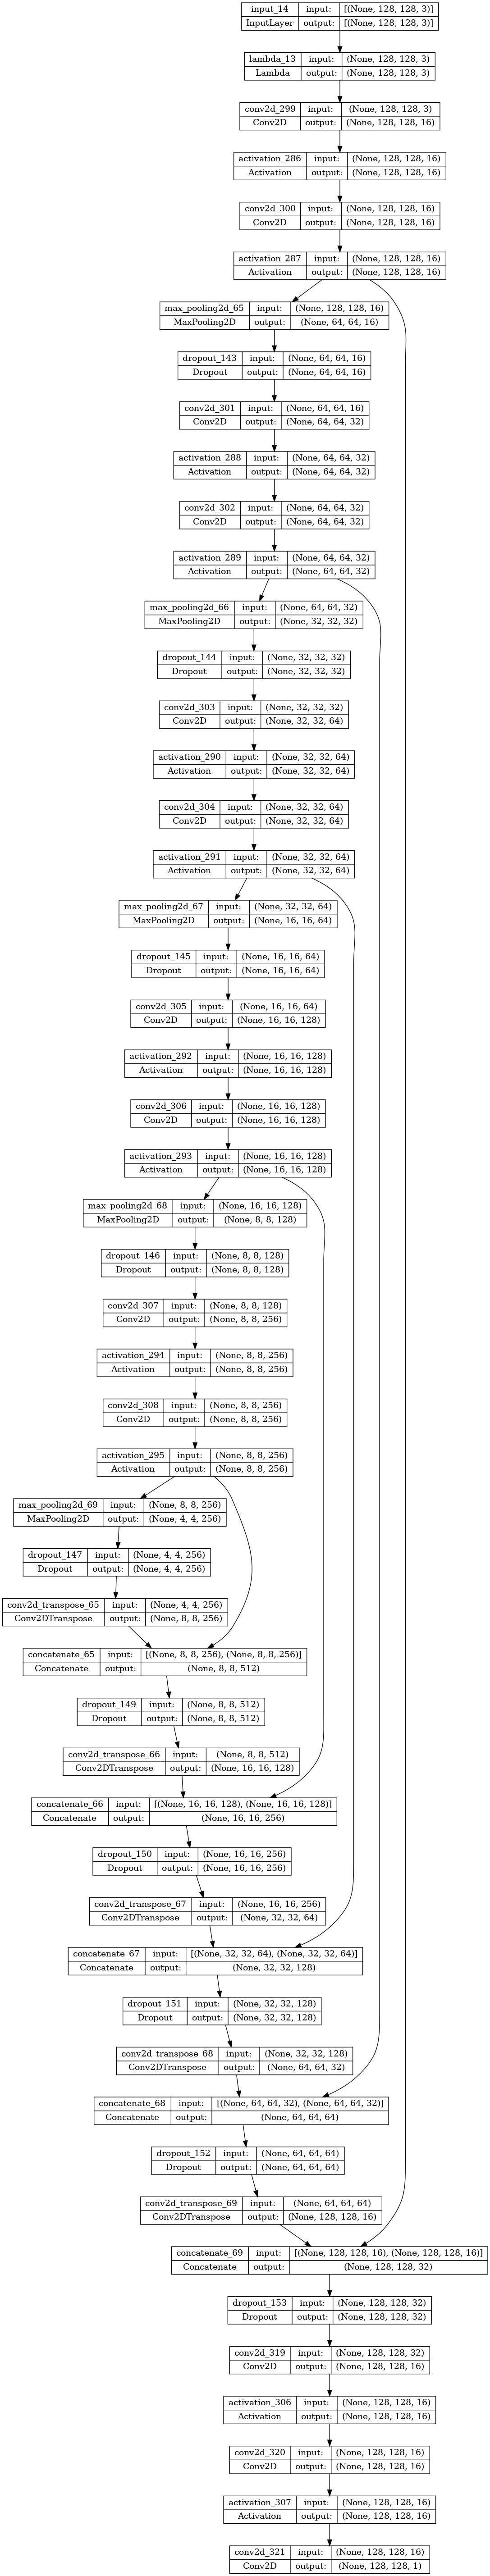

In [228]:
model.save('UNet.h5')
model.save('U_net_saved_model') 
tf.keras.utils.plot_model(model, show_shapes=True)

Model deployment:

We cannnot deploy model directly without optimizing.
There are several reasons why we cannot deploy a model directly without optimizing it:

Model size: The size of deep learning models is typically very large, making it difficult to deploy them on resource-constrained devices such as mobile phones or embedded systems. Therefore, optimizing the model helps to reduce the model size, making it easier to deploy.

Model speed: Deep learning models can be computationally expensive, requiring large amounts of computational resources to run. Optimizing the model can help reduce the computational cost of running the model, making it faster and more efficient.

Resource utilization: Optimizing a model can help to reduce the amount of memory and processing power required to run it, allowing for better utilization of available resources.

Accuracy: In some cases, optimizing a model can improve its accuracy. By fine-tuning the model and making it more efficient, it can potentially perform better on the data it was trained on, as well as on new, unseen data.

Compatibility: Models trained on one hardware or software environment may not be compatible with other environments. Optimizing the model can help to ensure compatibility with the target deployment environment.

After optimizing a deep learning model, it typically becomes more efficient, accurate, and faster to deploy. The optimization process involves several techniques such as pruning, quantization, and compression that help reduce the model's size and computational requirements while maintaining its performance.

By optimizing the model, we can make it more suitable for deployment on resource-constrained devices, such as mobile phones or IoT devices, where memory and processing power are limited. Additionally, optimized models can be deployed more quickly and at a lower cost than unoptimized models, making them more accessible to a wider range of users and applications.

Overall, optimizing a deep learning model is an essential step in the development and deployment process, and can help ensure that the model can be used effectively in a variety of real-world scenarios.

Deploy the trained model to the production environment and integrate it with the application or system for which it was designed.



In [229]:
##Model Optimization.. for Edge Devices.
##Importing Library for Optimization
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


### TF-TRT FP32 model

We first convert the TF native FP32 model to a TF-TRT FP32 model.

In [230]:

print('Converting to TF-TRT FP32...')

converter = trt.TrtGraphConverterV2(input_saved_model_dir='U_net_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.FP32,
                                    max_workspace_size_bytes=8000000000)
converter.convert()
converter.save(output_saved_model_dir='U_net_saved_modell_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...


2023-04-20 08:37:09.311847: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-04-20 08:37:09.312163: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-20 08:37:09.314138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14459 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0
2023-04-20 08:37:09.699019: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-04-20 08:37:09.699185: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-20 08:37:09.701163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14459 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, comp

Done Converting to TF-TRT FP32


In [231]:
# model = tf.keras.models.load_model("patth to model", custom_objects = {"iou": iou, "dice_coef": dice_coef})

### TF-TRT FP16 model
We next convert the native TF FP32 saved model to TF-TRT FP16 model.

In [232]:
import logging

converter = trt.TrtGraphConverterV2(input_saved_model_dir='U_net_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.FP16,
                                    max_workspace_size_bytes=8000000000)
converter.convert()
converter.save(output_saved_model_dir='U_net_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

2023-04-20 08:37:11.627775: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-04-20 08:37:11.627964: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-20 08:37:11.629906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14459 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0
2023-04-20 08:37:11.920342: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-04-20 08:37:11.920494: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-20 08:37:11.922312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14459 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, comp

Done Converting to TF-TRT FP16


### TF-TRT INT8 model

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.  


In [233]:
def calibration_input_fn():
    yield (batched_input, )
print('Converting to TF-TRT INT8...')

converter = trt.TrtGraphConverterV2(input_saved_model_dir='U_net_saved_model',
                                   precision_mode=trt.TrtPrecisionMode.INT8,
                                    max_workspace_size_bytes=8000000000)

converter.convert(calibration_input_fn=calibration_input_fn)
converter.save(output_saved_model_dir='U_net_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...


2023-04-20 08:37:14.631453: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-04-20 08:37:14.631638: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-20 08:37:14.633479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14459 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0
2023-04-20 08:37:14.894098: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-04-20 08:37:14.894261: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-20 08:37:14.896091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14459 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, comp

Done Converting to TF-TRT INT8


## Conclusion

In this notebook,  we have create a whole pipeline for Breast cancer segmentation -

(Data collection and preprocessing -> Model selection -> Model training -> Model evaluation -> Model testing -> Model deployment.)


and  demonstrated the process of creating TF-TRT FP32, FP16 and INT8 inference models from an original Keras FP32 model for fast and accurate model predication.

For Deployment we can use Docker .

Docker is a popular platform for packaging, deploying, and running applications in a portable way. Here are the steps to use Docker for deploying a deep learning model:

- Build a Docker image: Create a Dockerfile that specifies the dependencies required for your deep learning model. This could include the operating system, libraries, and any other dependencies. Then, build a Docker image from this Dockerfile using the docker build command.

- Load the model: Once you have the Docker image, you can load the trained deep learning model into it. This can be done by adding the model file to the Docker image or by downloading the model during runtime.

- Deploy the container: Once the model is loaded, you can deploy the Docker container using the docker run command. This will start the container and expose the necessary ports for communicating with the model.

- Test the model: After the container is running, you can test the model by sending requests to the exposed API endpoints. This could be -done using tools like curl or Postman.

- Scale the deployment: Docker makes it easy to scale your deployment by running multiple containers on different hosts or in a cluster.

Overall, Docker simplifies the deployment process for deep learning models by creating a portable environment that encapsulates all the dependencies and configurations required to run the model.

In [255]:
import pandas as pd

df = pd.read_csv('100_Epoch/data.csv')
df.head()

epoch  accuracy  dice_coef       iou      loss     lr  precision_5  \
0      0  0.927245   0.265014  0.156018  0.203934  0.001     0.686698   
1      1  0.946401   0.462570  0.307620  0.146084  0.001     0.758433   
2      2  0.963274   0.621742  0.459670  0.100184  0.001     0.839089   
3      3  0.975063   0.747356  0.604048  0.065814  0.001     0.886534   
4      4  0.983302   0.837586  0.723209  0.042041  0.001     0.911438   

   recall_5  val_accuracy  val_dice_coef   val_iou  val_loss  val_precision_5  \
0  0.147975      0.943454       0.357511  0.217884  0.158349         0.817115   
1  0.477434      0.954097       0.517061  0.349100  0.123447         0.713263   
2  0.662493      0.958541       0.618137  0.447691  0.107369         0.739527   
3  0.785698      0.956960       0.672768  0.507728  0.113699         0.696967   
4  0.874149      0.958215       0.711595  0.555218  0.153810         0.720071   

   val_recall_5  
0      0.305618  
1      0.636760  
2      0.680359  
3      0.742018  
4      0.713841

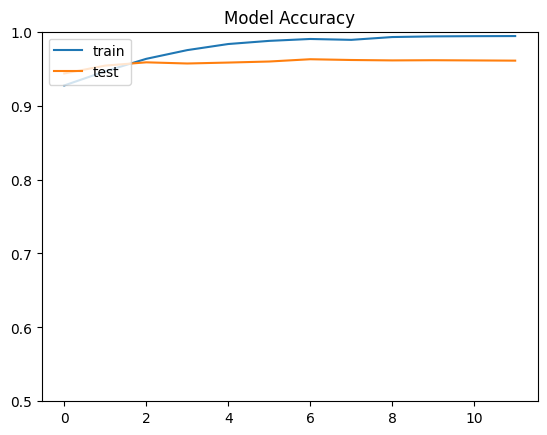

In [256]:
plt.plot(df['accuracy'])
plt.plot(df['val_accuracy'])
plt.title('Model Accuracy')
plt.ylim([0.5, 1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

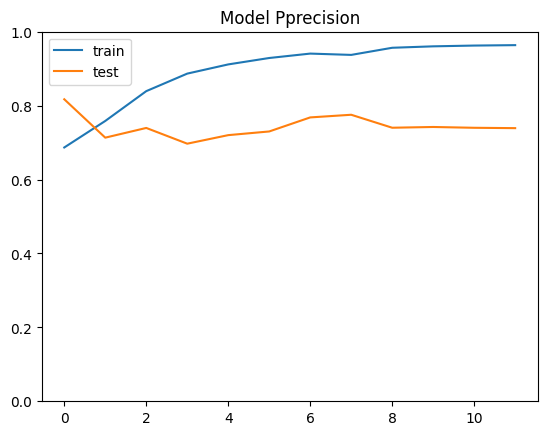

In [257]:
plt.plot(df['precision_5'])
plt.plot(df['val_precision_5'])
plt.title('Model Pprecision')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1])
plt.show()

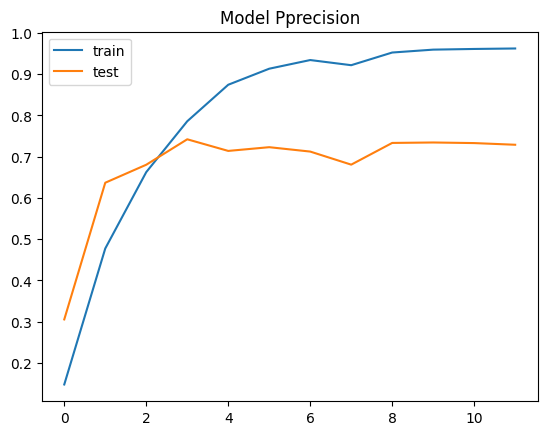

In [258]:
plt.plot(df['recall_5'])
plt.plot(df['val_recall_5'])
plt.title('Model Pprecision')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

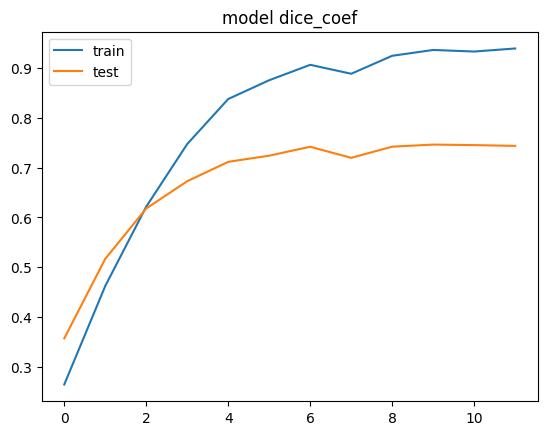

In [259]:
plt.plot(df['dice_coef'])
plt.plot(df['val_dice_coef'])
plt.title('model dice_coef')
plt.legend(['train', 'test'], loc='upper left')
plt.show()